# Image captioning network
---

"*Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions*"

Here we are implementing an image captioning network. The network will consist of an encoder and a decoder. The encoder is a convolutional neural network, and the decoder is a recurrent neural network. Producing reasonable textual description of an image is a hard task, however with the use of a CNN and a RNN we can start to generate somewhat plausible descriptions. 


Links:
- [1: Implementation](#Task1)
- [2: Train the recurrent neural network](#Task2)
- [: Generate image captions](#Task3)


Software version:
- Python 3.6
- Pytorch 1.0





---

### Evaluation format ###


You will be guided through the implementation step by step, and you can check your implementation at each step. Note, you will often need to complete all previous steps in order to continue.

In the implementation part, test functions allow you to check your code rapidly. when your code works, you can apply it on part 2 to train and part 3 to generate captions. Part 2, the training process, is slow and can run over night on a typical laptop computer. 

---

### Exercise content


All subtasks that you are to answer are found in this notebook. All implementation should be done in the file "cocoSource.py" found in folder "/sourceFiles/". The skeleton of the program is already implemented and contains things such as:
- Importing data
- Training framework
- Saving and restoring models


As mentioned, an image captioning network consists of an encoder and a decoder. Your task is to implement the decoder (RNN). The images have already been processed through a CNN. The feature vectors are stored in pickle files together with corresponding labels.


During task 1, you will implement all required functionalities for training the image captioning network. In task 2, you will train the network and study how different RNN arcitectures influences the loss. You will generate image captions from images in the validation set in task 3. 



---

### Dataset ###

We will use a dataset called "Common Object in Context" (COCO) 2017. It has ~120,000 training and 5,000 validation images. Every image also includes ~5 captions.

![](utils_images/bear.png)

Captions:

- A big burly grizzly bear is show with grass in the background.
- The large brown bear has a black nose.
- Closeup of a brown bear sitting in a grassy area.
- A large bear that is sitting on grass. 
- A close up picture of a brown bear's face.

---


### Network architecture ###

**Encoder**


Convolutional neural networks have shown to be useful for extracting high level features from images. We will use a pretrained VGG16 network trained on ImageNet. ImageNet consists of 1,2 million images distributed over 1000 classes, and we hope the model have learnt many general features. We are not interested in classifying the 1000 classes, and will change the last fully connected layer with our own. We will use a tanh actiation function to squeeze the values between -1 and 1 similar to the recurrent cells. 

**Decoder**

To be able to convert the high level features from the encoder to natural language, we will construct a recurrent neural network. The output of the encoder will be passed as the initial state to the recurrent cells. The input to the recurret neural network will be word embeddings which we will learn. 

**Loss function**

The words will be considered as separate classes and we shall use cross entropy loss.

**Training vs testing**

When we train the RNN, we will feed in the correct token (word) for every time step, see figure 2a. The words (tokens) are generally unknown, and in test mode, we will need to use our best estimate as input. Example, if the word "brown" has the highest probabillity after the softmax at timestep 2, we will feed in "brown" as input at timestep 3, see figure 2b.


<br>
<br>
<br>





In [ ]:
%%html
<img src="utils_images/image_captioning_diagram_train.png", width=2200>
Figure 2a: The figure shows an example with 3 recurrent cells stacked in train mode.

In [ ]:
%%html
<img src="utils_images/image_captioning_diagram_test.png", width=2200>
Figure 2b: The figure shows an example with 3 recurrent cells stacked in test mode.

<br>

---

### Vocabulary ###


To make good decisions in terms of the network architecture, we will need to know the statistics of the captions:
- The number of words in the captions (sequence length) should be considered when chooseing the truncated backpropagation length. 
- To save memory, it is normal to limit the vocabulary size/length. There will be a tradeoff between capturing all words and have a reansonble sized softmax layer. 


Note: The captions have been filtered such that all special characters have been removed. This includes also punctuations and commas. All characters have been changed to lower case.



----
**Vocabulary size**

To make good predictions we need the model to have the abillity to predict frequent words. Figure 3 shows a sorted histogram of the word count for the different words. We can see that the majority of the words are within the 2000 most frequent words. Figure 4 shows the precentage of the words accounted for as a function of the vocabulary size.

<br>


In [ ]:
%%html
<img src="utils_images/Word_count_hist.png", width=800>
*Figure 3*

In [ ]:
%%html
<img src="utils_images/accumulated_Word_count.png",width=800>
*Figure 4*

---


**Truncated backpropagation length**


The sequence length of the recurrent neural network should be able to capture the time(step) dependencies within the captions. Figure 5 shows a histogram of the caption counts as a function of the caption (/sequence) length. Figure 6 shows the precentage of all captions with shorter or equal caption length as a function of caption (/sequence) length. 

<br>

In [ ]:
%%html
<img src="utils_images/Sequence_lengths_hist.png", width=800>
*Figure 5*

In [ ]:
%%html
<img src="utils_images/accumulated_Sequence_length_count.png", width=800>
*Figure 6*

---

**Common words and their tokens**


Every word is assosiated with a token. The words are sorted such that the most frequent words have lower token values. In the table below, you find the six most common words in the dataset. The three first words/tokens have a spescial purpuse:
- "eeee": Indicates the end of a caption.
- "ssss": Start token, first word 
- "UNK": As the vocabulary size often is smaller than the number of words in the datasset, we change all "unknown" words to the word "UNK"


<br>




In [ ]:
%%html
<img src="utils_images/vocabulary.png", width=800>



---
### Word embedding  ###


The input to the first rnn layer is the embedded version of the input words. We will define a word embedding matrix with shape [vocabulary_size, embedding_size)]. A single word embedding will be a row vector with length [embedding_size]. The tokens are used to select the correct row within the word embedding matrix. For example, the word "a" will have values in the third row in the embedding matrix (where first row is row zero).


a_emb = wordEmbedding[a_token, :]


The word embedding matrix will be initialized with random values and they will be updated as part of the training process. The goal is that similar words get similar vector representations within the embedding matrix. This will not be part of the assigment, but as a test, the vector representations could be embedded using e.g. t-SNE for plotting in 2D/3D space.



--- 

### Data preparation  ###

Before starting to work on implementing the network aritecture, you should check if you need to download and process data:

- **UIO**: If you work on a IFI computer or one of the ML servers, we have already processed and made the data avaiable for you. The paths are given in the notebook.

- **Personal computer**: If you plan to work on the assigment on your personal computer, you will need to download and process the data yourself. Follow the steps in notebook "data_preparation.ipynb". Running the data preparation can take several hours. 

*Change the configuration below if you use CPU or GPU*



The processed data are pickle files holding the following information for every image:
- Path to the jpg image
- Captions
- Captions given as tokens
- The fc7 output from the VGG16 network.




<a id='Task1'></a>

---


# Task 1: Implementation #
See function headings for specification of each function.




** General advice**

Do not regenerate the data if you don't need it, it will run overnight on a laptop without GPU. Use either /opt/ifi/anaconda3/bin/jupyter notebook or the ml-servers. 

Part 1 is for developing your code and runs fairly fast. 
Part 2 does the actual captioning and can take some hours on CPU. 


Restarting the notebook after each subtask can be a good idea. 

In [ ]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
import autoreload

%load_ext autoreload
%autoreload 2

---

**Task 1a** 

Your are to implement a vanailla RNN class in the function RNNCell in file sourceFiles/cocoSource.py. The class shall have a constructor and the function "forward". To speed up inference, we will concatinate the input and the old state matrices and perform a single matrix multiplication. The difference is illustrated below.

Vanilla RNN:

\begin{align}
h_t &= tanh(x_tW^{hx} + h_{t-1}W^{hh} + b) \\
\\
h_t &= tanh([x_t,h_{t-1}]W + b)
\end{align}



In [ ]:
# Import modules
from sourceFiles import cocoSource
from unit_tests import unit_tests
import torch

# Defining dummy variables
hidden_state_sizes = 512
inputSize  = 256
batch_size = 128
x          = torch.tensor(torch.rand(batch_size, inputSize))
state_old  = torch.tensor(torch.rand(batch_size, hidden_state_sizes))

# You should implement this function
cell   = cocoSource.RNNCell(hidden_state_sizes, inputSize)
cell(x, state_old)

# Check implementation
unit_tests.RNNcell_test()

---

**Task 1b** 

Your are to implement a Gated recurrent units (GRU) class in the function GRUCell in cocoSource.py. The class shall have a constructor and the function "forward". To speed up inference, we will concatinate the input and the old state matrices and perform a single matrix multiplication. The difference is illustrated in the equations below, where you are to implement the equations in the column to the right.

GRU:

\begin{align}
&Update \: gate: \qquad &\Gamma^u=\sigma(x_tW^{u} + h_{t-1}U^{u} + b^u) \qquad \rightarrow \qquad &\Gamma^u=\sigma([x_t, h_{t-1}]W^{u} + b^u) \\
&Reset \: gate: \qquad &\Gamma^r=\sigma(x_tW^{r} + h_{t-1}U^{r} + b^r) \qquad \rightarrow \qquad &\Gamma^r=\sigma([x_t, h_{t-1}]W^{r} + b^r) \\
&Candidate \:cell: &\tilde{h_t} = tanh([x_tW + (\Gamma^r \circ h_{t-1})U + b) \qquad \rightarrow \qquad &\tilde{h_t} = tanh([x_t, (\Gamma^r \circ h_{t-1})] W + b) \\
&Final\: cell:    &h_t = \Gamma^u \circ h_{t-1} + (1-\Gamma^u) \circ \tilde{h_t} \qquad \rightarrow \qquad &h_t = \Gamma^u \circ h_{t-1} + (1-\Gamma^u) \circ \tilde{h_t}
\end{align}




In [ ]:
# Import modules
from sourceFiles import cocoSource
from unit_tests import unit_tests
import torch

# Defining dummy variables
hidden_state_sizes = 512
inputSize  = 648
batch_size = 128
x          = torch.tensor(torch.rand(batch_size, inputSize))
state_old  = torch.tensor(torch.rand(batch_size, hidden_state_sizes))

# You should implement this function
cell   = cocoSource.GRUCell(hidden_state_sizes, inputSize)
cell(x, state_old)

# Check implementation
unit_tests.GRUcell_test()

**Task 1c** 

Your task is to implement "loss_fn" in cocoSource.py. 

In [ ]:
from sourceFiles import cocoSource
from unit_tests import unit_tests
import torch

weight_dir = '/home/in54s039/oblig2/unit_tests/loss_fn_tensors.pt'
checkpoint = torch.load(weight_dir)

logits     = checkpoint['logits']
yTokens    = checkpoint['yTokens']
yWeights   = checkpoint['yWeights']

sumLoss, meanLoss = cocoSource.loss_fn(logits, yTokens, yWeights)

# Check implementation
unit_tests.loss_fn_test()

---

**Task 1d** 

You may want to have a look at "utils/trainer.py" and "utils/model.py" to understand the flow of the script.
Your task is to implement the  RNN class in cocoSource.py. 


In [ ]:
#####
from IPython.display import display_html
def restartkernel():
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
#####
    
    
# Import modules
from sourceFiles import cocoSource
from unit_tests import unit_tests
import torch

# Config
my_dir = '/home/in54s039/oblig2/unit_tests/RNN_tensors_is_train_True.pt'
checkpoint = torch.load(my_dir)

outputLayer   = checkpoint['outputLayer']
Embedding     = checkpoint['Embedding']
xTokens       = checkpoint['xTokens']
initial_hidden_state  = checkpoint['initial_hidden_state']
input_size            = checkpoint['input_size']
hidden_state_size     = checkpoint['hidden_state_size']
num_rnn_layers        = checkpoint['num_rnn_layers']
cell_type             = checkpoint['cell_type']
is_train              = checkpoint['is_train']

# You should implement this function
myRNN = cocoSource.RNN(input_size, hidden_state_size, num_rnn_layers, cell_type)
logits, current_state = myRNN(xTokens, initial_hidden_state, outputLayer, Embedding, is_train)

# Check implementation
is_train = True
unit_tests.RNN_test(is_train)

is_train = False
unit_tests.RNN_test(is_train)


# Restart the kernel for next run
#restartkernel()

---

**Task 1e** 

You should now implement the imageCaptionModel class. 

In [ ]:
# Import modules
from sourceFiles import cocoSource
from unit_tests import unit_tests

# Config
my_dir = '/home/in54s039/oblig2/unit_tests/imageCaptionModel_tensors.pt'
checkpoint = torch.load(my_dir)
config                            = checkpoint['config']
vgg_fc7_features                  = checkpoint['vgg_fc7_features']
xTokens                           = checkpoint['xTokens']
is_train                          = checkpoint['is_train']
myImageCaptionModelRef_state_dict = checkpoint['myImageCaptionModelRef_state_dict']
logitsRef                         = checkpoint['logitsRef']
current_hidden_state_Ref          = checkpoint['current_hidden_state_Ref']

myImageCaptionModel = cocoSource.imageCaptionModel(config)
logits, current_hidden_state = myImageCaptionModel(vgg_fc7_features, xTokens,  is_train)

# Check implementation
unit_tests.imageCaptionModel_test()

<a id='Task2'></a>

----


# Task 2: Train the image captioning network #


Congratulations, you are done with all implemention. You shall now train various network architectures. The weights will be stored regularly, but updated when the validation loss has decrease only. When you are done training you can go to task 3 to start generating captions. 

Depending on your compute power, the training can take a long time. Start with small simple network architectures.

The loss per epoch images will be stored in folder "loss_images"

In [1]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

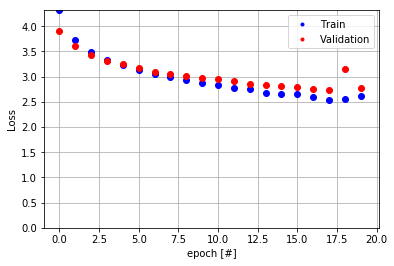

In [3]:
from utils.dataLoader import DataLoaderWrapper
from utils.saverRestorer import SaverRestorer
from utils.model import Model
from utils.trainer import Trainer
from utils.validate import plotImagesAndCaptions

#Path if you work on personal computer
#data_dir = 'data/coco/'

#Path if you work on UIO IFI computer
#data_dir = '/projects/in5400/oblig2/coco/'

#Path if you work on one of the ML servers
data_dir = '/shared/in5400/coco/'

#train
modelParam = {
        'batch_size': 128,          # Training batch size
        'cuda': {'use_cuda': True, # Use_cuda=True: use GPU
                 'device_idx': 1},  # Select gpu index: 0,1,2,3
        'numbOfCPUThreadsUsed': 3,  # Number of cpu threads use in the dataloader
        'numbOfEpochs': 20,         # Number of epochs
        'data_dir': data_dir,       # data directory
        'img_dir': 'loss_images/',
        'modelsDir': 'storedModels/',
        'modelName': 'model_1/',    # name of your trained model
        'restoreModelLast': 0,
        'restoreModelBest': 0,
        'modeSetups':   [['train', True], ['val', True]],
        'inNotebook': True,         # If running script in jupyter notebook
        'inference': False
}

config = {
        'optimizer': 'adam',             # 'SGD' | 'adam' | 'RMSprop'
        'learningRate': {'lr': 0.0005},  # learning rate to the optimizer
        'weight_decay': 0,               # weight_decay value
        'VggFc7Size': 4096,              # Fixed, do not change
        'embedding_size': 128,           # word embedding size
        'vocabulary_size': 4000,         # number of different words
        'truncated_backprop_length': 20,
        'hidden_state_sizes': 256,       #
        'num_rnn_layers': 2,             # number of stacked rnn's
        'cellType': 'RNN'                # RNN or GRU
        }


# create an instance of the model you want
model = Model(config, modelParam)

# create an instacne of the saver and resoterer class
saveRestorer = SaverRestorer(config, modelParam)
model        = saveRestorer.restore(model)

# create your data generator
dataLoader = DataLoaderWrapper(config, modelParam)

# here you train your model
trainer = Trainer(model, modelParam, config, dataLoader, saveRestorer)
trainer.train()

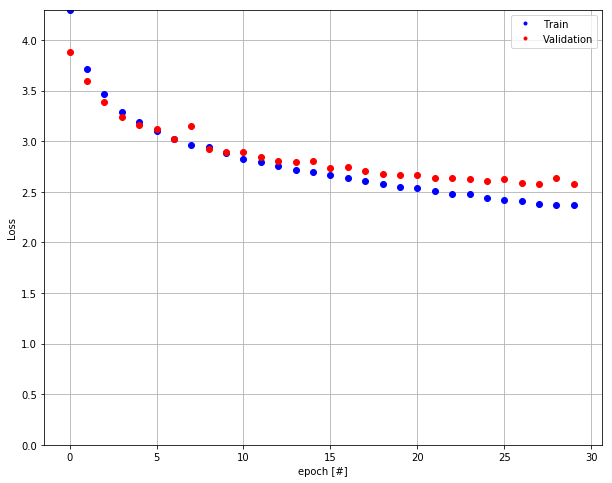

In [99]:
from utils.dataLoader import DataLoaderWrapper
from utils.saverRestorer import SaverRestorer
from utils.model import Model
from utils.trainer import Trainer
from utils.validate import plotImagesAndCaptions

#Path if you work on personal computer
#data_dir = 'data/coco/'

#Path if you work on UIO IFI computer
#data_dir = '/projects/in5400/oblig2/coco/'

#Path if you work on one of the ML servers
data_dir = '/shared/in5400/coco/'

#train
modelParam = {
        'batch_size': 64,          # Training batch size
        'cuda': {'use_cuda': True, # Use_cuda=True: use GPU
                 'device_idx': 3},  # Select gpu index: 0,1,2,3
        'numbOfCPUThreadsUsed': 4,  # Number of cpu threads use in the dataloader
        'numbOfEpochs': 30,         # Number of epochs
        'data_dir': data_dir,       # data directory
        'img_dir': 'loss_images/',
        'modelsDir': 'storedModels/',
        'modelName': 'model_2/',    # name of your trained model
        'restoreModelLast': 0,
        'restoreModelBest': 0,
        'modeSetups':   [['train', True], ['val', True]],
        'inNotebook': True,         # If running script in jupyter notebook
        'inference': False
}

config = {
        'optimizer': 'adam',             # 'SGD' | 'adam' | 'RMSprop'
        'learningRate': {'lr': 0.0003},  # learning rate to the optimizer
        'weight_decay': 0,               # weight_decay value
        'VggFc7Size': 4096,              # Fixed, do not change
        'embedding_size': 128,           # word embedding size
        'vocabulary_size': 3000,         # number of different words
        'truncated_backprop_length': 20,
        'hidden_state_sizes': 256,       #
        'num_rnn_layers': 4,             # number of stacked rnn's
        'cellType': 'RNN'                # RNN or GRU
        }


# create an instance of the model you want
model = Model(config, modelParam)

# create an instacne of the saver and resoterer class
saveRestorer = SaverRestorer(config, modelParam)
model        = saveRestorer.restore(model)

# create your data generator
dataLoader = DataLoaderWrapper(config, modelParam)

# here you train your model
trainer = Trainer(model, modelParam, config, dataLoader, saveRestorer)
trainer.train()

<a id='Task3'></a>

---

# Task 3: Generate image captions on the validation set#

In [24]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
from utils.dataLoader import DataLoaderWrapper
from utils.saverRestorer import SaverRestorer
from utils.model import Model
from utils.trainer import Trainer
from utils.validate import plotImagesAndCaptions

#Path if you work on personal computer
#data_dir = 'data/coco/'

#Path if you work on UIO IFI computer
#data_dir = /projects/in5400/oblig2/coco/

#Path if you work on one of the ML servers
data_dir = '/shared/in5400/coco/'

modelParam = {
        'batch_size': 64,          # Training batch size
        'cuda': {'use_cuda': True, # Use_cuda=True: use GPU
                 'device_idx': 3},  # Select gpu index: 0,1,2,3
        'numbOfCPUThreadsUsed': 4,  # Number of cpu threads use in the dataloader
        'numbOfEpochs': 30,         # Number of epochs
        'data_dir': data_dir,       # data directory
        'img_dir': 'loss_images/',
        'modelsDir': 'storedModels/',
        'modelName': 'model_2/',    # name of your trained model
        'restoreModelLast': 0,
        'restoreModelBest': 0,
        'modeSetups':   [['train', True], ['val', True]],
        'inNotebook': True,         # If running script in jupyter notebook
        'inference': True
}

config = {
        'optimizer': 'adam',             # 'SGD' | 'adam' | 'RMSprop'
        'learningRate': {'lr': 0.0003},  # learning rate to the optimizer
        'weight_decay': 0,               # weight_decay value
        'VggFc7Size': 4096,              # Fixed, do not change
        'embedding_size': 128,           # word embedding size
        'vocabulary_size': 3000,         # number of different words
        'truncated_backprop_length': 20,
        'hidden_state_sizes': 256,       #
        'num_rnn_layers': 4,             # number of stacked rnn's
        'cellType': 'RNN'                # RNN or GRU
        }

if modelParam['inference'] == True:
    modelParam['batch_size'] = 1
    modelParam['modeSetups'] = [['val', False]]
    modelParam['restoreModelBest'] = 1

# create an instance of the model you want
model = Model(config, modelParam)

# create an instacne of the saver and resoterer class
saveRestorer = SaverRestorer(config, modelParam)
model        = saveRestorer.restore(model)

# create your data generator
dataLoader = DataLoaderWrapper(config, modelParam)

You can run the cell below to generate captions.

In [1]:
# plotImagesAndCaptions
plotImagesAndCaptions(model, modelParam, config, dataLoader)

NameError: name 'plotImagesAndCaptions' is not defined